# Learning to Extract Pain Outcomes from Clinical Text without Labeled Data
## II: Discriminative Model

We train 2 standard discriminative model:

- Sparse Logisitic Regression
- Bidirectional Long Short Term Memory (LSTM)
 
Logistic regression requires manual feature engineering while the LSTM is a standard, state-of-the-art approach for relation extraction problems.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import numba
import numpy as np
import matplotlib

from snorkel import SnorkelSession
from snorkel.learning.disc_models.rnn import *
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels
from snorkel.models import candidate_subclass, Document, Sentence, Candidate, Span
from snorkel.learning import GenerativeModel
from rwe.labelers import *

In [4]:
session = SnorkelSession()

try:
    PainLocation = candidate_subclass('PainLocation', ['pain', 'anatomy'])
except:
    pass

### Load Candidates and Gold Labels

In [12]:
train_cands = session.query(Candidate).filter(Candidate.split == 0).order_by(Candidate.id).all()
dev_cands   = session.query(Candidate).filter(Candidate.split == 1).order_by(Candidate.id).all()
test_cands  = session.query(Candidate).filter(Candidate.split == 2).order_by(Candidate.id).all()

L_gold_train = load_gold_labels(session, split=0, annotator_name='gold')
L_gold_dev   = load_gold_labels(session, split=1, annotator_name='gold')
L_gold_test  = load_gold_labels(session, split=2, annotator_name='gold')

print "Candidates [TRAIN]", len(train_cands)
print "Candidates [DEV]  ", len(dev_cands)
print "Candidates [TEST] ", len(test_cands)

print "Gold [TRAIN]", L_gold_train.shape[0]
print "Gold [DEV]  ", L_gold_dev.shape[0]
print "Gold [TEST] ", L_gold_test.shape[0]

# Depending on your choice of parser, some candidates might be identified that were not originally
# labeled in our gold test set. This hack just sets those unknown labels to negative
L_gold_train[L_gold_train == 0] = -1
L_gold_dev[L_gold_dev == 0]     = -1
L_gold_test[L_gold_test == 0]   = -1

Candidates [TRAIN] 225
Candidates [DEV]   63
Candidates [TEST]  168
Gold [TRAIN] 225
Gold [DEV]   63
Gold [TEST]  168


In [5]:
documents = session.query(Document).all()

In [6]:
print len(train_cands)
print len(dev_cands)
print len(test_cands)

candidates = train_cands + dev_cands + test_cands

225
63
168


In [7]:
from rwe.labelers import *

# get our pain/anatomy relation labeling functions
lfs = get_labeling_functions("pain_anatomy")

print "Loaded {} labeling functions\n".format(len(lfs))


Loaded 25 labeling functions



In [8]:
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(lfs=lfs)
L_train = labeler.load_matrix(session, split=0)
L_dev   = labeler.load_matrix(session, split=1)

print L_train.shape
print L_dev.shape

(225, 25)
(63, 25)


## Sparse Logistic Regression

### Create Features
This uses a standard NLP feature generation library using lemmatization, POS tags, and sentence dependency parsing to generate candidate features.

In [9]:
from snorkel.annotations import FeatureAnnotator
from rwe.features import hybrid_span_mention_ftrs

featurizer = FeatureAnnotator(hybrid_span_mention_ftrs)

F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_test  = featurizer.load_matrix(session, split=2)

F_train = F_train if F_train.size != 0 else featurizer.apply(split=0)
F_dev   = F_dev if F_dev.size != 0 else featurizer.apply_existing(split=1)
F_test  = F_test if F_test.size != 0 else featurizer.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%

Clearing existing...
Running UDF...
[========================================] 100%



## Supervised Labels

In [10]:
from sklearn.metrics import f1_score,recall_score,precision_score

In [17]:
from snorkel.annotations import load_marginals
from snorkel.annotations import load_gold_labels
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

train_marginals = load_marginals(session, split=0)

## Train Discriminitive Model

In [46]:
from snorkel.learning import SparseLogisticRegression
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

num_model_search = 5

# use grid search to optimize the generative model
step_size_param     = ListParameter('step_size', [0.01 / L_train.shape[0]])
decay_param         = ListParameter('lr', [1e-3, 1e-2])
l1_param            = ListParameter('l1_penalty', [1e-4, 1e-2])
l2_param            = ListParameter('l2_penalty', [1e-4, 1e-2])
balance_param       = ListParameter('rebalance', [0.5])

# search for the best model
param_grid = [step_size_param, decay_param, l1_param, l2_param, balance_param]

searcher = RandomSearch(SparseLogisticRegression, param_grid, F_train, 
                        train_marginals, n=num_model_search, seed=seed)

disc_model, run_stats = searcher.fit(X_valid=F_dev, Y_valid=L_gold_dev, n_threads=1, 
                                     n_epochs=500, print_freq=100)

run_stats

Initialized RandomSearch search of size 5. Search space size = 8.
[1] Testing step_size = 4.44e-05, lr = 1.00e-02, l1_penalty = 1.00e-04, l2_penalty = 1.00e-04, rebalance = 5.00e-01
disc_learning: random seed 1234
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=174  #epochs=500  batch size=174
[SparseLogisticRegression] Epoch 0 (0.02s)	Average loss=0.937851
[SparseLogisticRegression] Epoch 100 (1.53s)	Average loss=0.436457
[SparseLogisticRegression] Epoch 200 (2.92s)	Average loss=0.435393
[SparseLogisticRegression] Epoch 300 (4.47s)	Average loss=0.435336
[SparseLogisticRegression] Epoch 400 (6.03s)	Average loss=0.435343
[SparseLogisticRegression] Epoch 499 (7.43s)	Average loss=0.435346
[SparseLogisticRegression] Training done (7.43s)
[SparseLogisticRegression] F1 Score: 0.615384615385
[SparseLogisticRegression] Model saved in <checkpoints> as <SparseLogisticRegression_0>
[2] Testing step_size = 4.44e-05, lr = 1.00e-02, l1_penalty = 1.00e-02, l2_penalty = 1.

,step_size,lr,l1_penalty,l2_penalty,rebalance,Prec.,Rec.,F1
2,0.000044,0.001,0.0100,0.0100,0.5,0.629630,0.708333,0.666667
0,0.000044,0.010,0.0001,0.0001,0.5,0.571429,0.666667,0.615385
1,0.000044,0.010,0.0100,0.0001,0.5,0.571429,0.666667,0.615385
3,0.000044,0.010,0.0001,0.0001,0.5,0.571429,0.666667,0.615385
4,0.000044,0.010,0.0001,0.0001,0.5,0.571429,0.666667,0.615385


In [47]:
from snorkel.models import GoldLabel, GoldLabelKey, Label, LabelKey, Feature, FeatureKey, Candidate

In [48]:
tp, fp, tn, fn = disc_model.error_analysis(session, F_test, L_gold_test, b=0.5)

Scores (Un-adjusted)
Pos. class accuracy: 0.826
Neg. class accuracy: 0.672
Precision            0.487
Recall               0.826
F1                   0.613
----------------------------------------
TP: 38 | FP: 40 | TN: 82 | FN: 8



array([<matplotlib.axes._subplots.AxesSubplot object at 0x122131c90>],
      dtype=object)

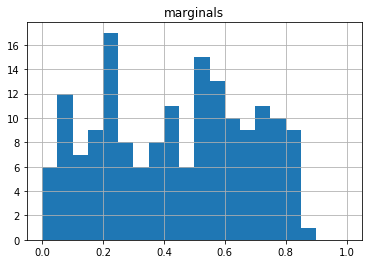

In [49]:
m = disc_model.marginals(F_test)
fig, ax = plt.subplots()
df = pd.DataFrame(data=m, columns=['marginals'])
pd.DataFrame.hist(df,range=(0.0, 1.0),bins=20, ax=ax)

## LSTM

Long Short Term Memory (LSTM) models can acheive state-of-the-art performance on many text classification tasks. We'll train a simple bidirectional LSTM model below.

In deep learning, hyperparameter tuning is very important and computationally expensive step in training models. For purposes of this tutorial, we've pre-selected some settings so that you can train a model in under 10 minutes. Advanced users can look at our Grid Search Tutorial for more details on choosing these parameters.

In [52]:
np.random.seed(0)

def get_max_seq_len(cands):
    l = 0
    for c in cands:
        l = max(len(c[0].sentence.words),l)
    print "max seq len", l
    return l

attn_window      = ListParameter('attn_window', [10])
batch_size_param = ListParameter('batch_size', [32, 64])
rate_param       = RangeParameter('lr', 1e-4, 1e-2, step=1, log_base=10)
dropout_param    = RangeParameter('dropout', 0.0, 0.5, step=0.25)
dim_param        = ListParameter('dim', [50, 100])

param_grid = [attn_window, batch_size_param, rate_param, dropout_param, dim_param]
searcher = RandomSearch(reRNN, param_grid, train_cands, train_marginals, n=num_model_search, seed=seed)

# search for the best model
disc_model, run_stats = searcher.fit(X_valid=dev_cands, Y_valid=L_gold_dev, n_threads=1, 
                                     n_epochs=100, print_freq=10)

run_stats

Initialized RandomSearch search of size 5. Search space size = 36.
[1] Testing attn_window = 10, batch_size = 32, lr = 1.00e-03, dropout = 0.00e+00, dim = 50
disc_learning: random seed 1234
[reRNN] Training model
[reRNN] n_train=213  #epochs=10  batch size=32
[reRNN] Epoch 0 (3.12s)	Average loss=0.679233
[reRNN] Epoch 9 (30.38s)	Average loss=0.502762
[reRNN] Training done (30.38s)
[reRNN] F1 Score: 0.590163934426
[reRNN] Model saved in <checkpoints> as <reRNN_0>
[2] Testing attn_window = 10, batch_size = 64, lr = 1.00e-03, dropout = 0.00e+00, dim = 100
disc_learning: random seed 1234
[reRNN] Training model
[reRNN] n_train=213  #epochs=10  batch size=64
[reRNN] Epoch 0 (3.21s)	Average loss=0.660391
[reRNN] Epoch 9 (43.98s)	Average loss=0.527911
[reRNN] Training done (43.98s)
[reRNN] F1 Score: 0.716981132075
[reRNN] Model saved in <checkpoints> as <reRNN_1>
[3] Testing attn_window = 10, batch_size = 64, lr = 1.00e-02, dropout = 0.00e+00, dim = 100
disc_learning: random seed 1234
[reRNN] 

,attn_window,batch_size,lr,dropout,dim,Prec.,Rec.,F1
1,10,64,0.0010,0.00,100,0.655172,0.791667,0.716981
0,10,32,0.0010,0.00,50,0.486486,0.750000,0.590164
4,10,64,0.0100,0.25,50,0.428571,0.375000,0.400000
2,10,64,0.0100,0.00,100,0.411765,0.291667,0.341463
3,10,32,0.0001,0.50,50,0.000000,0.000000,0.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1292046d0>],
      dtype=object)

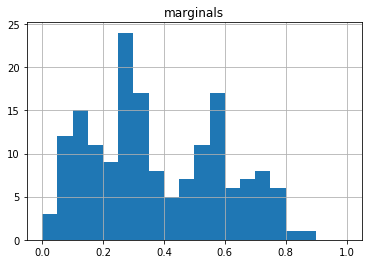

In [56]:
m = disc_model.marginals(test_cands)

fig, ax = plt.subplots()
df = pd.DataFrame(data=m, columns=['marginals'])
pd.DataFrame.hist(df,range=(0.0, 1.0),bins=20, ax=ax)

In [58]:
tp, fp, tn, fn = disc_model.error_analysis(session, test_cands, L_gold_test, b=0.5)

Scores (Un-adjusted)
Pos. class accuracy: 0.565
Neg. class accuracy: 0.746
Precision            0.456
Recall               0.565
F1                   0.505
----------------------------------------
TP: 26 | FP: 31 | TN: 91 | FN: 20

